In [1]:
import math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.special as special
import scipy.stats as stats
%matplotlib inline
import toolkit_eric as tke
import os

In [2]:
def get_fname(n, quiet = False):
    dir_list = os.listdir('.')
    filename = None
    for item in dir_list:
        try:
            header = item[:item.find('_')]
            if int(header) == n:
                if quiet == False:
                    print( item )
                filename = item
                break
        except:
            pass
    
    if filename == None:
        print( "get_fname() error: File " + str(n) + " not found!" )
    return filename

def val_var_str(val, var, fstr = 'auto'):
    sig = var**0.5
    if fstr == 'auto':
        o_val = math.floor( math.log10( abs(val) ) )
        o_sig = math.floor( math.log10( abs(sig) ) )
        
        sdig = int(o_val - o_sig + 1)
        # print o_val, o_sig, sdig
        if sdig < 1:
            sdig = 1
        sdig_str = '{:1.0f}'.format( sdig )
        # print sdig_str
        
        val_fmt = '{:.' + sdig_str + 'g}'
        val_var_str = val_fmt.format(val) + ' +/- ' + '{:.1g}'.format(sig)
        return val_var_str
    else:    
        return fstr.format(val) + ' +/- ' + fstr.format(var**0.5)

def mw_scan(filename, n = 3, plot = False):
    # Load Data
    data = np.loadtxt(filename)
    data[:,1] = cav_cuts(data[:,1])
    data = tke.lin_ave(data,n)
    freq = data[:,0]/1.0e9
    amps = data[:,1]
    
    fr_m = freq[ np.argmin(amps) ]
    
    if plot == True:
        plt.plot(freq, amps, 'k-')
        plt.axvline(fr_m, color = 'blue')
        plt.grid(True)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Reflected Power (arb. u.)')
        plt.title('Peak = ' + str(fr_m) + ' GHz')
    
    return freq, amps, fr_m

def cav_cuts(amps, n=5):
    while True:
        damp = abs(np.diff(amps))
        ave = np.mean(damp)
        stdev = np.std(damp)
        i = np.argmax(damp)
        # print i, damp[i], ave + 5*stdev
        
        if damp[i] > ave + n*stdev:
            for j in range(i+1, len(amps)):
                amps[j] = amps[j] * amps[i]/(amps[i] + damp[i])
        else:
            break
    
    return amps

def cav_fit(freq, amps, p0):
    # popt, pcov = optimize.curve_fit(cauchy_5, freq, amps, p0)
    popt, pcov = optimize.curve_fit(cauchy_4, freq, amps, p0)
    # print popt
    # amps_fit = cauchy_5(freq, popt[0], popt[1], popt[2], popt[3], popt[4])
    amps_fit = cauchy_4(freq, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, amps_fit

def cauchy_5(x, amp, width, x0, m, y0):
    return amp*width**2 / ( (x-x0)**2 + width**2 ) + m*(x-x0) + y0

def cauchy_4(x, amp, width, x0, y0):
    return amp*width**2 / ( (x-x0)**2 + width**2 ) + y0

def laser_scan(filename, n = 10, plot = False):
    # Load Data
    data = np.loadtxt(filename)
    data = tke.lin_ave(data, n)
    freq = data[:,1]
    norm = data[:,2]
    no_b = data[:,3]
    sign = data[:,4]
    si_b = data[:,5]
    
    si_n = (sign - si_b)/(norm - no_b)
    
    if plot == True:
        plt.plot(freq, si_n, 'k-')
        plt.grid(True)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Rydberg Signal')
    
    return freq, si_n

# def erfc_4(x, amp, width, x0, y0):
#     return amp/2.0*special.erfc( (x-x0)/width ) + y0

def erfc_4(x, amp, width, x0, y0):
    return 0.5*amp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0

def fit_erfc_4(freq, si_n, p0):
    popt, pcov = optimize.curve_fit(erfc_4, freq, si_n, p0)
    si_n_fit = erfc_4(freq, popt[0], popt[1], popt[2], popt[3])
    
    return popt, pcov, si_n_fit

def erfc_lin_5(x, amp, width, x0, y0, m):
    return 0.5*amp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0 + m*(x-x0)

def fit_erfc_lin_5(x, y, p0):
    popt, pcov = optimize.curve_fit(erfc_lin_5, x, y, p0)
    y_fit = erfc_lin_5(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    
    return popt, pcov, y_fit

def erfc_4_amp(x, width, x0, y0):
    return 0.5*hardamp*special.erfc( (x-x0)/(2.0**0.5*width) ) + y0

def fit_erfc_4_amp(freq, si_n, p0):
    
    popt, pcov = optimize.curve_fit(erfc_4_amp, freq, si_n, p0)
    si_n_fit = erfc_4_amp(freq, popt[0], popt[1], popt[2])
    
    return popt, pcov, si_n_fit


# def limit_scan(filename, n = 10, plot = False):
#     freq, si_n = laser_scan(filename, n, False)
#     p0 = (1.0, 10.0, -10.0, 0.0)
#     popt, pcov, si_n_fit = fit_erfc(freq, si_n)
#     
#     if plot == True:
#         plt.plot(freq, si_n, 'k-')
#         plt.plot(freq, si_n_fit, 'b-')
#         plt.xlabel('Frequency (GHz)')
#         plt.ylabel('Signal (arb. u.)')
#         plt.grid(True)
#         plt.title( 'limit = ' + val_var_str(popt[2], pcov[2,2]**0.5)
#                    + ' GHz' )
#     
#     return freq, si_n, np.array([[popt[0], pcov[0,0]**0.5],
#                      [popt[1], pcov[1,1]**0.5],
#                      [popt[2], pcov[2,2]**0.5],
#                      [popt[3], pcov[3,3]**0.5]])

# -----

def dist(step):
    m = 0.0002539 # mm/step
    b = 44.60     # mm
    return 2*m*step + b

def wavelength(step, df):
    m = 0.0002539 # mm/step
    wl = 299792458.0*1.0e3 / (df*1.0e9*1.00029) # wavelength (mm) at 17.8 GHz
    # print wl
    return 2*m*step /wl

# def delay_scan(filename, n, df, plot = False):
#     steps, nsig = tke.dyescan(filename, n)
#     wlng = wavelength(steps, df)
# 
#     wl = 299792458.0*1.0e3 / (df*1.0e9*1.00029) # wavelength (mm) at 17.8 GHz
# 
#     # initial guesses
#     a0_amp   = ( max(nsig) - min(nsig) )/2.0
#     a0_phase = wlng[np.argmax(nsig)]
#     a0_mean  = np.mean(nsig)
#     a0 = np.array([a0_amp, a0_phase, a0_mean])
#     fit, cov = optimize.curve_fit(cos_off, wlng, nsig, a0)
#     a = fit
#     # fitted data
#     fit_y = cos_off(wlng, a[0], a[1], a[2])
# 
#     # printing
#     # print a0
#     # print a
# 
#     # plotting
#     # plt.figure(figsize = (10,10))
#     if plot == True:
#         plt.plot(wlng, nsig, 'b.-')
#         plt.plot(wlng, fit_y, 'k-', linewidth = 3)
#         plt.grid(True)
#     
#     return wlng, nsig, fit_y, cov

def fit_cos_off(wlng, nsig):
    
    # initial guesses
    a0_amp   = ( max(nsig) - min(nsig) )/2.0
#     a0_freq  = 2.0*np.pi
    a0_phase = wlng[np.argmax(nsig)]
    a0_mean  = np.mean(nsig)
    a0 = np.array([a0_amp, a0_phase, a0_mean])
    fit = optimize.curve_fit(cos_off, wlng, nsig, a0)
    
    return fit[0]

def cos_off(x, a0, a1, a2):
    return a0*np.cos( 2.0*np.pi*(x - a1) ) + a2

def cos_3(x, amp, x0, y0):
    return amp*np.cos( 2.0*np.pi*(x-x0) ) + y0

def fit_cos_3(x, y, p0):
    popt, pcov = optimize.curve_fit(cos_3, x, y, p0)
    y_fit = cos_3(x, popt[0], popt[1], popt[2])
    return popt, pcov, y_fit

def cos_4(x, amp, x0, m, y0):
    return amp*np.cos( 2.0*np.pi*(x-x0) ) + m*x + y0

def fit_cos_4(x, y, p0):
    popt, pcov = optimize.curve_fit(cos_4, x, y, p0)
    y_fit = cos_4(x, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, y_fit

# -----

def gauss_4(x, amp, x0, width, off):
    return amp*np.exp(-(x-x0)**2.0/(2*width**2)) + off

def fit_gauss_4(x, y, p0):
    popt, pcov = optimize.curve_fit(gauss_4, x, y, p0)
    y_fit = gauss_4(x, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, y_fit

# -----

def piece_6(x, x1, y1, x2, y2, x3, y3):
    y = np.zeros(len(x)) - 9.0
    for i in range(len(x)):
        if x[i]<=x1:
            y[i] = y1
        elif x[i]>x1 and x[i]<=x2:
            y[i] = (y2-y1)/(x2-x1)*(x[i]-x1) + y1
        elif x[i]>x2 and x[i]<=x3:
            y[i] = (y3-y2)/(x3-x2)*(x[i]-x2) + y2
        elif x[i]>x3:
            y[i] = y3
        else:
            y[i] = -9
    
    return y

def fit_piece_6(x, y, p0):
    popt, pcov = optimize.curve_fit(piece_6, x, y, p0)
    y_fit = piece_6(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
    return popt, pcov, y_fit

def folder():
    return os.path.relpath('.', '..')

In [3]:
# Compactified Functions

def simple_scan(fnum, n_ave=0, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # plot data
    if quiet==False:
        plt.figure(figsize=(8,6))
        plt.plot(freq, si_n, 'k-')
        plt.xlabel('Frequency (GHz)', size=14)
        plt.ylabel('Normalized Rydberg Signal', size=14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size=14)
        plt.grid(True)
        plt.tight_layout()

def limit_scan(fnum, n_ave=0, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # fit data
    p0 = [1.0, 10.0, -10.0, 0.0, 0.0] # amp, width, limit, offset, slope
    popt, pcov, si_n_fit = fit_erfc_lin_5(freq, si_n, p0)
    # half amplitude limit
    lim_amp  = (popt[0]+popt[3])/2
    lim_i    = np.argmin( abs(si_n_fit-lim_amp) )
    lim_freq = freq[lim_i]
    # print useful numbers
    if quiet == False:
        print( 'simple limit = ', lim_freq, ' GHz' )
        print( 'limit = ',
               val_var_str(popt[2], pcov[2,2], '{:.2f}'),
               ' GHz' ) 
        print( 'width = ',
               val_var_str(2.35*popt[1], 2.35**2*pcov[1,1], '{:.2f}'),
               ' GHz' )
        print( 'zero = ', val_var_str(popt[3], pcov[3,3], '{:.3f}') )
        print( 'amp = ', val_var_str(popt[0], pcov[0,0], '{:.3f}') )
        print( 'slope = ', val_var_str(popt[4], pcov[4,4], '{:.3g}') )
    lim_amp = si_n_fit[np.argmin(np.abs(freq-popt[2]))]
    # plot data
    if quiet == False:
        plt.figure(figsize = (8,6))
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 3)
        plt.axvline(popt[2], color = 'red', linestyle = 'dashed')
        plt.axhline(lim_amp, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename + '    '
                  + 'limit = ' + val_var_str(popt[2], pcov[2,2], '{:.2f}')
                  + ' GHz',
                  size = 14)
        plt.grid(True)
        plt.show()
    # return useful stuff
    if quiet == True:
        return freq, si_n, si_n_fit, popt, pcov
    else:
        return

def mwext_scan(fnum, n_ave=3, quiet=False):
    # get data
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    # fit data
    p0 = [1.0, 10.0, -10.0, 0.0]
    popt, pcov, si_n_fit = fit_erfc_4(freq, si_n, p0)
    # half amplitude limit
    lim_amp = (popt[0]+popt[3])/2
    lim_i = np.argmin( abs(si_n_fit-lim_amp) )
    lim_freq = freq[lim_i]
    # print useful numbers
    if quiet == False:
        print( 'simple limit = ', lim_freq, ' GHz' )
        print( 'limit = ', val_var_str(popt[2], pcov[2,2], '{:.2f}'), ' GHz' ) 
        print( 'width = ', val_var_str(2.35*popt[1], 2.35**2*pcov[1,1], '{:.2f}'), ' GHz' )
        print( 'zero = ', val_var_str(popt[3], pcov[3,3], '{:.3f}') )
        print( 'amp = ', val_var_str(popt[0], pcov[0,0], '{:.3f}') )
    lim_amp = si_n_fit[np.argmin(np.abs(freq-popt[2]))]
    # plot data
    if quiet == False:
        plt.figure(figsize = (8,6))
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 3)
        plt.axvline(popt[2], color = 'red', linestyle = 'dashed')
        plt.axhline(lim_amp, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    
def mwa_scan(fnum, n_ave=0, quiet=False):
    # get data
    filename = get_fname(fnum)
    data = np.loadtxt(filename)
    isort = np.argsort(data[:,0])
    data = data[isort,:]
    freq = data[:,0]/1.0e9
    sign = -data[:,1]
    fmax = freq[np.argmax(sign)]
    # fit data
    p0 = np.array([0.23, fmax, 0.0010, 0.03])
    popt, pcov, gauss_fit = fit_gauss_4(freq, sign, p0)
    # print useful numbers
    if quiet == False:
        print( 'Gauss f0 = ', val_var_str(popt[1], pcov[1,1]), ' GHz' )
        print( 'Gauss FWHM = ', val_var_str(2.35*popt[2], 2.35**2*pcov[2,2]), ' GHz' )
    p0 = np.array([0.23, 0.0010, fmax, 0.03])
    popt, pcov, cauchy_fit = cav_fit(freq, sign, p0)
    if quiet == False:
        print( 'Cauchy f0 = ', val_var_str(popt[2], pcov[2,2]), ' GHz' )
        print( 'Cauchy FWHM = ', val_var_str(2*popt[1], 2**2*pcov[1,1]), ' GHz' )
    # plot data
    if quiet == False:
        plt.figure(figsize = (8,6))
        plt.plot(freq, sign, 'k.', label='data')
        plt.plot(freq, gauss_fit, 'b-', label='Gauss')
        plt.plot(freq, cauchy_fit, 'g-', label='Cauchy')
        plt.xlabel('MW Frequency (GHz)', size = 14)
        plt.ylabel('Signal (arb. u.)', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    # return
    if quiet == True:
        return freq, sign, cauchy_fit, popt, pcov
    else:
        return
    
def mwres_scan(fnum_pro, fnum_100, df, norms=[0.0,1.0], f0=-12, n_ave=2, quiet=False):
    # unpack norms
    zero = norms[0]
    max_amp = norms[1]
    # get DL-Pro scan
    filename = get_fname(fnum_pro)
    freq_pro, si_n_pro = laser_scan(filename, n_ave, False)
    si_n_pro = si_n_pro/(max_amp+zero)
    # get DL-100 scan
    filename = get_fname(fnum_100)
    if filename != None:
        freq_100, si_n_100 = laser_scan(filename, n_ave, False)
        si_n_100 = si_n_100/(max_amp+zero)
    # plot
    if quiet == False:
        plt.figure(figsize = (8,6))
        plt.plot(freq_pro, si_n_pro, 'b.')
        if filename != None:
            plt.plot(freq_100, si_n_100, 'g.')
        for i in range(-2,3):
            plt.axvline(f0 + i*df, color = 'red', linestyle = 'dashed')
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Rydberg Signal', size = 14)
        if filename != None:
            plt.title(os.path.relpath('.', '..') + '    ' + filename,
                      size = 14)
        plt.grid(True)
    if quiet == True:
        return freq_pro, si_n_pro, freq_100, si_n_100
    else:
        return

def delay_scan(fnum, df, norms=[0.0,1.0], n_ave=2, quiet=False):
    # unpack norms
    zero = norms[0]
    max_amp = norms[1]
    # get data
    filename = get_fname(fnum)
    data = np.loadtxt(filename)
    isort = np.argsort(data[:,1])
    data = data[isort,:]
    data = tke.lin_ave(data, n_ave)
    delay = data[:,1]
    norm = data[:,2]
    no_b = data[:,3]
    sign = data[:,4]
    si_b = data[:,5]
    si_n = (sign - si_b)/(norm - no_b)
    # normalize
    si_n = (si_n-zero)/max_amp
    wlng = wavelength(delay, df)
    # fit data
    p0 = [0.0, 0.0, 0.5]
    popt, pcov, si_n_fit = fit_cos_3(wlng, si_n, p0)
    # print useful numbers
    if quiet == False:
        print( 'mean = ', val_var_str(popt[2], pcov[2,2]) )
        print( 'pk-pk = ', val_var_str(2.0*abs(popt[0]), 2.0**2*pcov[0,0]) )
        if popt[0]>0:
            print( 'phase = ', val_var_str(popt[1]%1, pcov[1,1]) )
        else:
            print( 'phase = ', val_var_str(popt[1]%1+0.5, pcov[1,1]) )
    # plot data
    if quiet == False:
        # plt.figure(figsize = (8,6))
        plt.plot(wlng, si_n, 'k.')
        plt.plot(wlng, si_n_fit, 'b-', linewidth = 3)
        if popt[0]>0:
            plt.axvline(np.mod(popt[1], 1), color='red', linestyle='dashed')
        else:
            plt.axvline(np.mod(popt[1], 1)+0.5, color='red', linestyle='dashed')
        plt.axhline(popt[2], color = 'red', linestyle = 'dashed')
        plt.xlabel(r'Delay (MW $\lambda$)', size = 14)
        plt.ylabel('Normalized Rydberg Signal', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename,
                  size = 14)
        plt.grid(True)
    if quiet == False:
        return
    else:
        return wlng, si_n, si_n_fit, popt, pcov
    
def pndmtv_scan(fnum, df, n_ave=2, quiet=False):
    # get DL-Pro scan
    filename = get_fname(fnum)
    freq, si_n = laser_scan(filename, n_ave, False)
    freq = freq/df
    p0 = [0.1, 4.0, 0.0, 0.0]
    popt, pcov, si_n_fit = fit_cos_4(freq, si_n, p0)
    freq = freq*df
    if quiet == False:
        x0 = popt[0]*df
        if popt[0]<0:
            x0 = x0-df
        x0 = x0%(df/2)
        
        print( 'x0 = ' + '\t' + '{:.2f}'.format((popt[1]*df)%(df/2)) )
    if quiet == False:
        plt.figure(figsize = (8,6))
        plt.plot(freq, si_n, 'k.')
        plt.plot(freq, si_n_fit, 'b-', linewidth = 2)
        for i in range(-2, 2):
            plt.axvline((popt[1]*df)%(df/2)+i*df)
        plt.xlabel('Frequency (GHz)', size = 14)
        plt.ylabel('Rydberg Signal (arb. u.)', size = 14)
        plt.title(os.path.relpath('.', '..') + '    ' + filename, size =14)
        plt.grid(True)
    if quiet == False:
        return
    else:
        return freq, si_n, si_n_fit, popt, pcov

In [4]:
def get_dscan(fnum,f):
    data = np.loadtxt(get_fname(fnum));
    data = data[ np.argsort(data[:,1]), : ]
    dscan = np.array([ data[:,1], (data[:,4]-data[:,5]) / (data[:,2]-data[:,3]) ])
    dscan[0] = wavelength(dscan[0],f)
    return dscan

def norm(dscan):
    return np.array([ dscan[0], dscan[1]/np.mean(dscan[1]) ])

def quickplot(datas, labels):
    plt.figure(figsize=(6, len(datas)*1))
    for i in range(len(datas)):
        plt.subplot(len(datas),1,i+1)
        data = datas[i]
        lab = labels[i] 
        plt.plot(data[0], data[1], label=lab)
        plt.yticks(plt.ylim())
        plt.legend()
    plt.tight_layout()
    plt.show()
    return

def dscan_b(datas, labels):
    # unpack
    up = datas[0]
    um = datas[1]
    lp = datas[2]
    lm = datas[3]
    
    # normalize
    upn = norm(up)
    umn = norm(um)
    lpn = norm(lp)
    lmn = norm(lm)
    
    # background
    usn = 0.5*(upn+umn)
    lsn = 0.5*(lpn+lmn)
    bsn = 0.5*(usn+lsn)
    
    # background corrected data
    upb = np.array([ up[0], (upn[1]/bsn[1])*np.mean(up[1]) ])
    umb = np.array([ um[0], (umn[1]/bsn[1])*np.mean(um[1]) ])
    lpb = np.array([ lp[0], (lpn[1]/bsn[1])*np.mean(lp[1]) ])
    lmb = np.array([ lm[0], (lmn[1]/bsn[1])*np.mean(lm[1]) ])
    
    # repackage
    return [upb, umb, lpb, lmb], ['upb', 'umb', 'lpb', 'lmb']

def dscan_fit(data):
    p0 = [0.0, 0.0, np.mean(data[1])]
    popt, pcov, si_n_fit = fit_cos_3(data[0], data[1], p0)
    amp, phase, mean = popt[0], popt[1], popt[2]
    phase = phase%1
    if phase>0.5:
        amp=-amp
    phase = phase%0.5
    
    return amp, phase, mean


5_delay.txt
6_delay.txt
7_delay.txt
8_delay.txt
10_delay.txt
11_delay.txt
12_delay.txt
13_delay.txt
14_delay.txt
15_delay.txt
16_delay.txt
17_delay.txt
18_delay.txt
19_delay.txt
20_delay.txt
21_delay.txt
23_delay.txt
24_delay.txt
25_delay.txt
26_delay.txt
27_delay.txt
28_delay.txt
29_delay.txt
30_delay.txt
31_delay.txt
32_delay.txt
33_delay.txt
34_delay.txt
35_delay.txt
36_delay.txt
[-6000. -4000. -3000. -2000. -1500. -1000.  -800.  -600.  -400.  -300.
  -200.  -150.  -100.   -50.     0.     0.    50.   100.   150.   200.
   300.   400.   600.   800.  1000.  1500.  2000.  3000.  4000.  6000.]


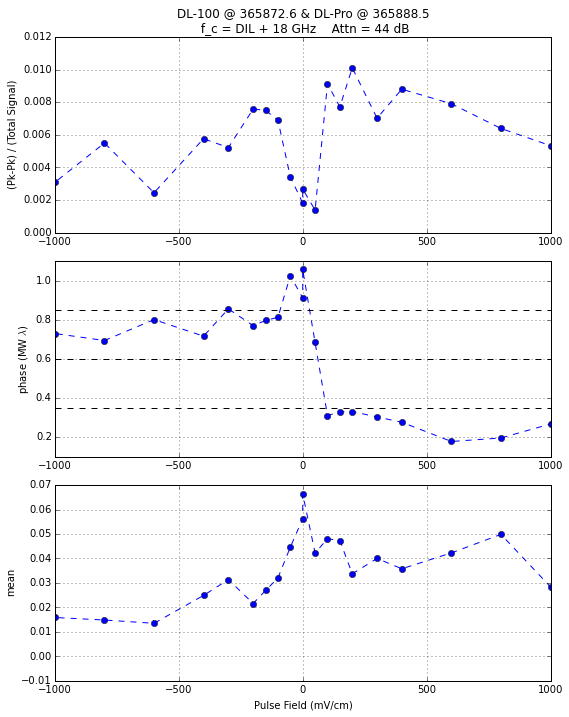

36_delay.txt
mean =  0.0082 +/- 0.0002
pk-pk =  0.0015 +/- 0.0005
phase =  0.99 +/- 0.05


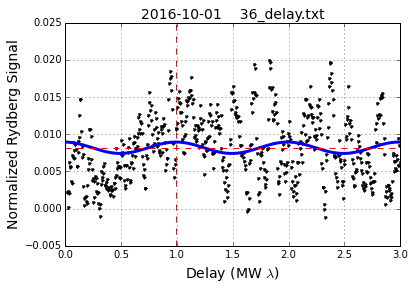

35_delay.txt
mean =  -0.0028 +/- 0.0002
pk-pk =  0.002 +/- 0.0005
phase =  0.99 +/- 0.04


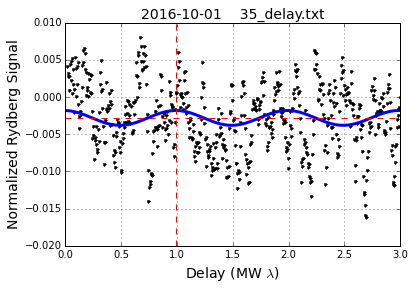

34_delay.txt
mean =  0.027 +/- 0.0002
pk-pk =  0.0014 +/- 0.0004
phase =  1.43 +/- 0.05


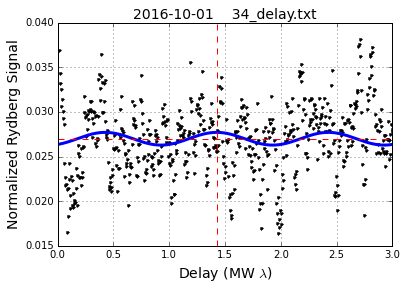

33_delay.txt
mean =  -0.003 +/- 0.0002
pk-pk =  0.0007 +/- 0.0005
phase =  0.5 +/- 0.1


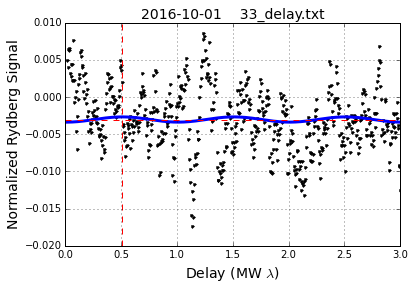

32_delay.txt
mean =  0.006 +/- 0.0002
pk-pk =  0.0014 +/- 0.0006
phase =  0.04 +/- 0.06


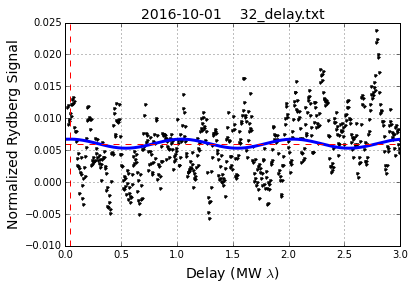

31_delay.txt
mean =  0.0158 +/- 0.0002
pk-pk =  0.0034 +/- 0.0005
phase =  0.05 +/- 0.02


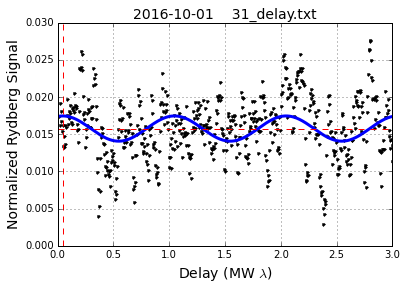

30_delay.txt
mean =  0.0415 +/- 0.0002
pk-pk =  0.0027 +/- 0.0005
phase =  0.77 +/- 0.03


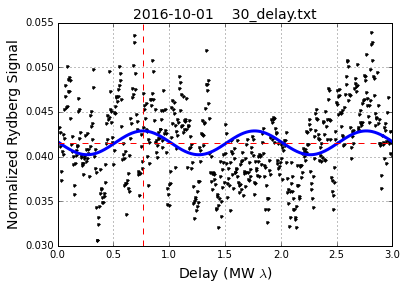

29_delay.txt
mean =  0.0103 +/- 0.0002
pk-pk =  0.0039 +/- 0.0006
phase =  1.31 +/- 0.02


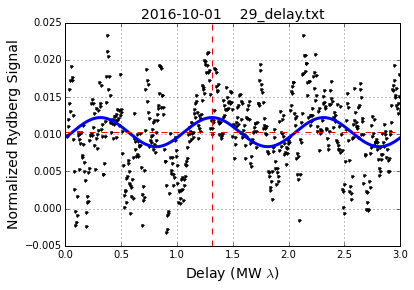

28_delay.txt
mean =  0.0498 +/- 0.0002
pk-pk =  0.0064 +/- 0.0005
phase =  0.2 +/- 0.01


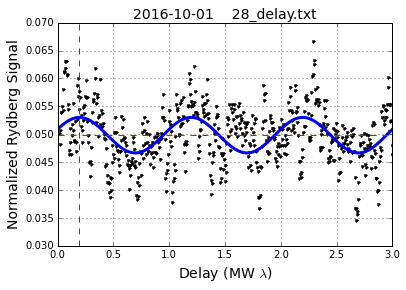

27_delay.txt
mean =  0.0221 +/- 0.0002
pk-pk =  0.0028 +/- 0.0006
phase =  0.91 +/- 0.03


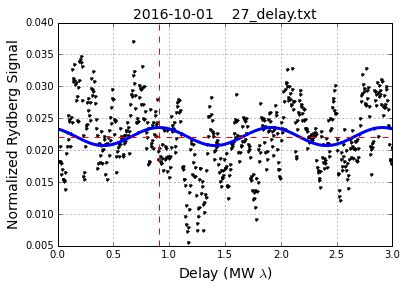

26_delay.txt
mean =  0.0073 +/- 0.0002
pk-pk =  0.0028 +/- 0.0005
phase =  1.39 +/- 0.03


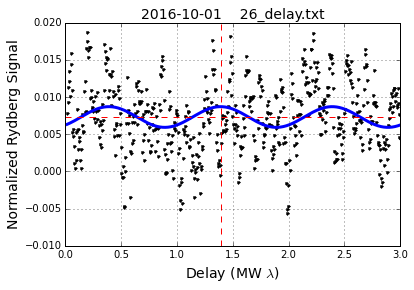

25_delay.txt
mean =  0.0284 +/- 0.0002
pk-pk =  0.0053 +/- 0.0006
phase =  1.27 +/- 0.02


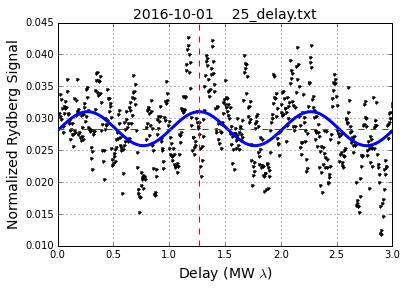

24_delay.txt
mean =  0.0159 +/- 0.0002
pk-pk =  0.0031 +/- 0.0005
phase =  0.73 +/- 0.03


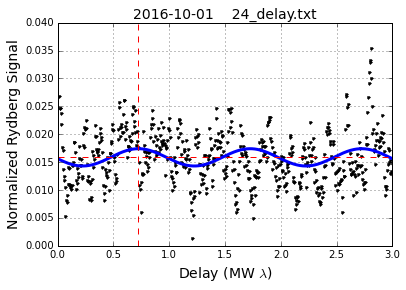

23_delay.txt
mean =  0.0148 +/- 0.0002
pk-pk =  0.0055 +/- 0.0006
phase =  0.69 +/- 0.02


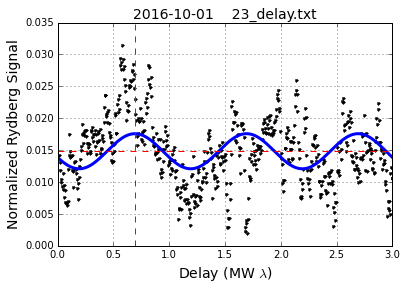

21_delay.txt
mean =  0.0562 +/- 0.0002
pk-pk =  0.0018 +/- 0.0006
phase =  0.91 +/- 0.05


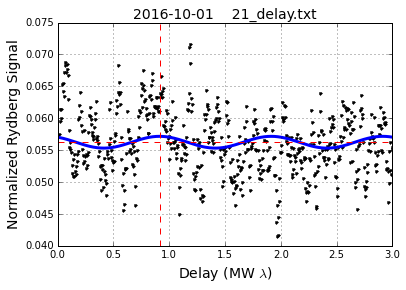

20_delay.txt
mean =  0.0422 +/- 0.0002
pk-pk =  0.0078 +/- 0.0006
phase =  0.18 +/- 0.01


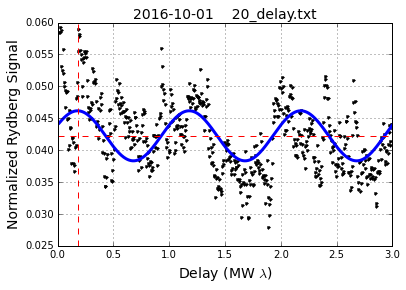

19_delay.txt
mean =  0.0135 +/- 0.0002
pk-pk =  0.0024 +/- 0.0005
phase =  0.8 +/- 0.04


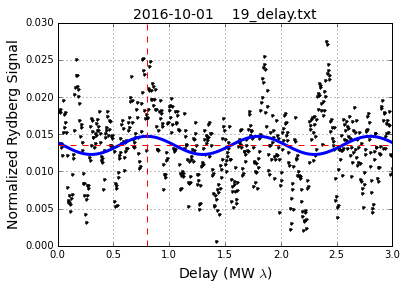

18_delay.txt
mean =  0.0249 +/- 0.0002
pk-pk =  0.0058 +/- 0.0006
phase =  0.71 +/- 0.02


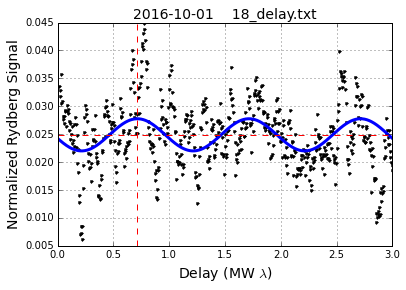

17_delay.txt
mean =  0.0358 +/- 0.0002
pk-pk =  0.0088 +/- 0.0007
phase =  1.28 +/- 0.01


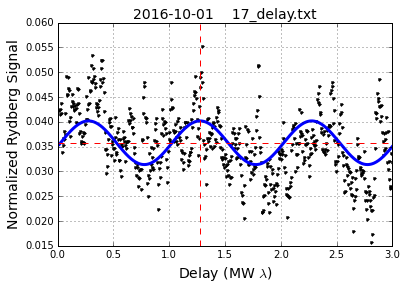

16_delay.txt
mean =  0.04 +/- 0.0002
pk-pk =  0.007 +/- 0.0007
phase =  1.3 +/- 0.01


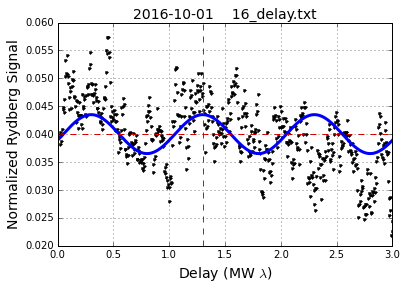

15_delay.txt
mean =  0.0314 +/- 0.0002
pk-pk =  0.0052 +/- 0.0005
phase =  0.86 +/- 0.02


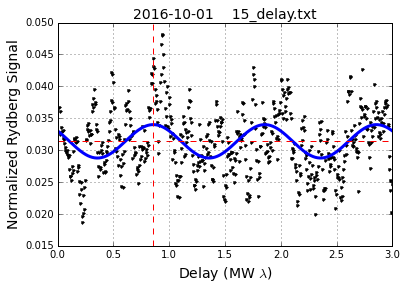

14_delay.txt
mean =  0.0269 +/- 0.0002
pk-pk =  0.0075 +/- 0.0006
phase =  0.79 +/- 0.01


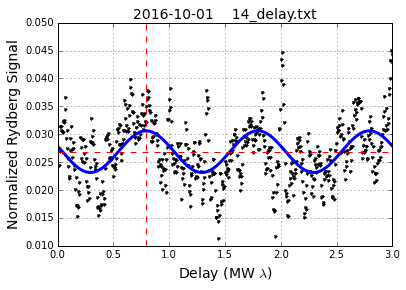

13_delay.txt
mean =  0.0473 +/- 0.0002
pk-pk =  0.0077 +/- 0.0006
phase =  1.33 +/- 0.01


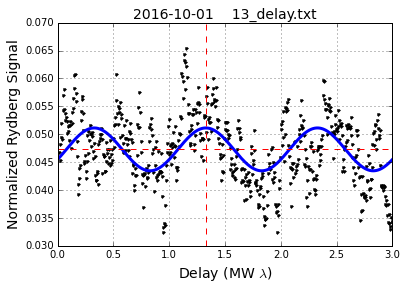

12_delay.txt
mean =  0.0422 +/- 0.0002
pk-pk =  0.0014 +/- 0.0006
phase =  0.67 +/- 0.07


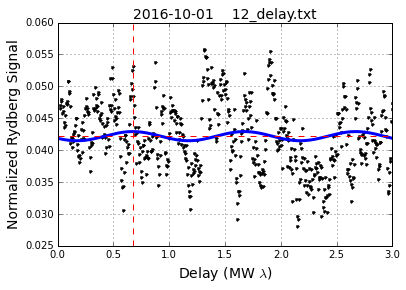

11_delay.txt
mean =  0.0446 +/- 0.0002
pk-pk =  0.0034 +/- 0.0007
phase =  0.02 +/- 0.03


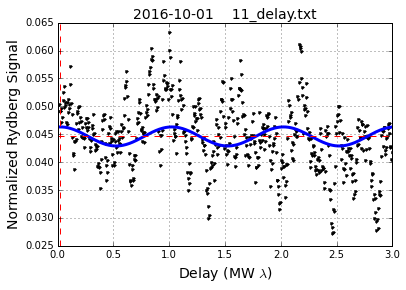

10_delay.txt
mean =  0.0664 +/- 0.0002
pk-pk =  0.0028 +/- 0.0006
phase =  0.06 +/- 0.03


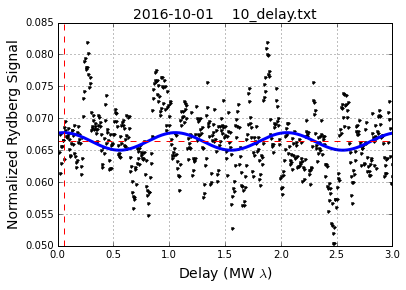

8_delay.txt
mean =  0.0337 +/- 0.0002
pk-pk =  0.0101 +/- 0.0005
phase =  1.331 +/- 0.008


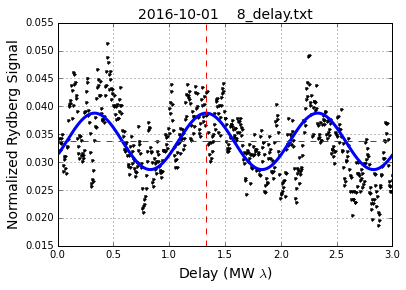

7_delay.txt
mean =  0.0216 +/- 0.0002
pk-pk =  0.0076 +/- 0.0005
phase =  0.77 +/- 0.01


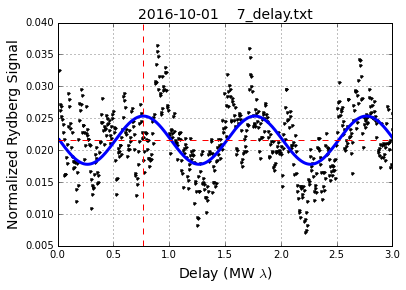

6_delay.txt
mean =  0.032 +/- 0.0002
pk-pk =  0.0069 +/- 0.0005
phase =  0.81 +/- 0.01


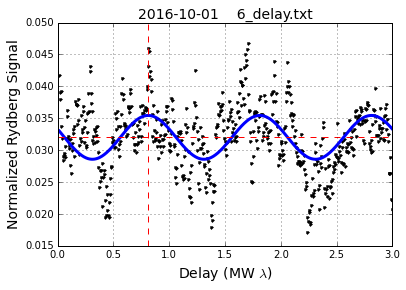

5_delay.txt
mean =  0.0481 +/- 0.0002
pk-pk =  0.0091 +/- 0.0005
phase =  1.31 +/- 0.01


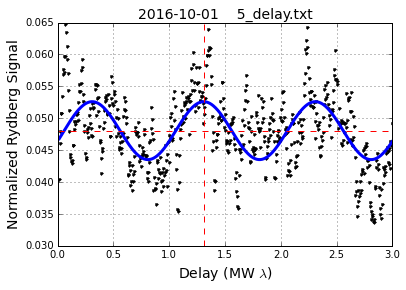

In [8]:
# get datafile list
fmap = 'dscanmap.txt'
mapdata = np.loadtxt(fmap)
# print(mapdata)
# [fnum, DL-Pro, DL=100, MW f, attn, fpulse]
# select slice
# mapdata = mapdata[ np.where(mapdata[:,2]==365891.5) ]
mapdata = mapdata[ np.where(mapdata[:,4]==44) ]
fnums   = mapdata[:,0]
dlpro   = mapdata[:,1]
dl100   = mapdata[:,2]
fmws    = mapdata[:,3]
attns   = mapdata[:,4]
fpulses = mapdata[:,5]


# set up arrays
means = np.zeros(len(mapdata))
phases = np.zeros(len(mapdata))
amps = np.zeros(len(mapdata))
mwfs = np.power(10, (45-attns)/20)

phasethresh = 0.6

# get file info
for i in range(len(mapdata)):
    wlng, si_n, si_n_fit, popt, pcov = delay_scan(fnums[i], fmws[i], quiet=True)
    mean = popt[2]
    phase = popt[1]
    amp = popt[0]
    # correct
    if amp<0:
        phase=phase-0.5
    phase=phase%1
    amp = abs(amp)
    if ((phase+(0.5-phasethresh))%1)<0.5:
        amp = -amp
    phase = (phase+(0.5-phasethresh))%1 - (0.5-phasethresh)
    # build arrays
    means[i] = mean
    phases[i] = phase
    amps[i] = amp

xdata = fpulses
# sortmask = 
isort = np.argsort(xdata)

xdata   =   xdata[isort]
mwfs    =    mwfs[isort]
attns   =   attns[isort]
means   =   means[isort]
phases  =  phases[isort]
amps    =    amps[isort]
fpulses = fpulses[isort]

# print( attns, '\n', mwfs )
print( xdata )

plt.figure(figsize=(8,10))
xlimits = (-1000,1000)

plt.subplot(311)
plt.title('DL-100 @ 365872.6 & DL-Pro @ 365888.5 \n f_c = DIL + 18 GHz    Attn = 44 dB')
plt.plot(xdata, 2*abs(amps), 'o--')
plt.axhline(0, color='black')
plt.xlim(xlimits)
plt.ylabel('(Pk-Pk) / (Total Signal)')
plt.grid(True)

plt.subplot(312)
for offset in [0]:
    plt.plot(xdata, phases+offset, 'bo--')
plt.axhline(phasethresh, color='black', linestyle='dashed')
plt.axhline(phasethresh+0.25, color='black', linestyle='dashed')
plt.axhline(phasethresh-0.25, color='black', linestyle='dashed')
plt.xlim(xlimits)
plt.ylim(phasethresh-0.5, phasethresh+0.5)
plt.ylabel(r'phase (MW $\lambda$)')
plt.grid(True)

plt.subplot(313)
plt.plot(xdata, means, 'bo--', label='mean')
# plt.plot(xdata, np.absolute(amps/means), '^--', label='contrast')
plt.xlim(xlimits)
plt.xlabel('Pulse Field (mV/cm)')
plt.ylabel('mean')
# plt.ylim(0,0.25)
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.savefig('fpulse.pdf')
plt.show()

for i in range(len(mapdata)):
    j = -1-i
    plt.figure()
    delay_scan(fnums[j], fmws[j], n_ave=3)
    plt.show()

In [7]:
outarray = np.vstack( (fpulses, means, amps, phases) )
outarray = np.transpose(outarray)
np.savetxt('out.txt', outarray)